In [1]:
import sys
import logging
import pickle
import yaml
import matplotlib.cm as cm
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from configs import engram_dir

# Parameters

In [2]:
internal_dim = 24
generic_exp_name = 'lineartrack'
network_yaml = 'dm'
pre_episode = 50
post_episode = 600

In [3]:
exp_name = f'{generic_exp_name}_{network_yaml}_dim{internal_dim}'
latents_dir = f'{engram_dir}latents/{exp_name}/'
nnets_dir = f'{engram_dir}nnets/{exp_name}/'
pickle_dir = f'{engram_dir}pickles/{exp_name}/'
analysis_dir = f'{engram_dir}analysis/{exp_name}/'

# Load analyses dataframes

In [4]:
with open(f'{analysis_dir}representation_df_ep{pre_episode}.p', 'rb') as f:
    pre_repr_df = pickle.load(f)
with open(f'{analysis_dir}transition_df_ep{pre_episode}.p', 'rb') as f:
    pre_T_df = pickle.load(f)
    
with open(f'{analysis_dir}representation_df_ep{post_episode}.p', 'rb') as f:
    post_repr_df = pickle.load(f)
with open(f'{analysis_dir}transition_df_ep{post_episode}.p', 'rb') as f:
    post_T_df = pickle.load(f)

# Helper functions

In [5]:
def retrieve_lineartrack(heatmap):
    receptive_field = []
    receptive_field.extend(list(heatmap[1,1:-1]))
    receptive_field.extend(list(heatmap[2:-1,-2]))
    receptive_field.extend(list(heatmap[-2,-3:0:-1]))
    receptive_field.extend(list(heatmap[-3:0:-1,1]))
    return receptive_field

# Make transition network receptive fields

In [6]:
np.unique(pre_T_df['model'])

array(['lineartrack_g0_-2_entro-2', 'lineartrack_noq_g0_-2_entro-2'],
      dtype=object)

In [7]:
model = f'{generic_exp_name}_g0_-2_entro-2'
n_actions = 4

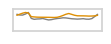

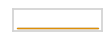

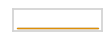

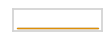

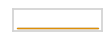

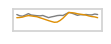

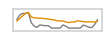

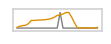

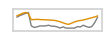

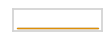

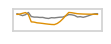

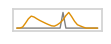

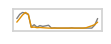

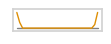

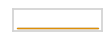

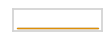

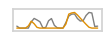

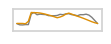

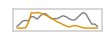

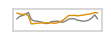

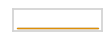

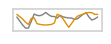

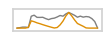

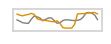

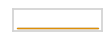

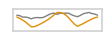

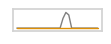

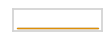

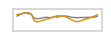

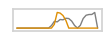

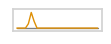

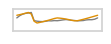

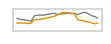

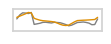

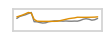

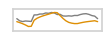

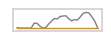

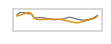

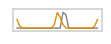

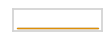

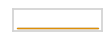

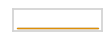

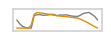

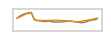

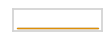

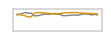

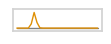

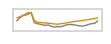

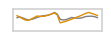

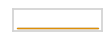

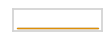

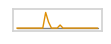

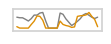

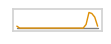

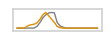

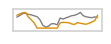

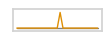

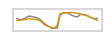

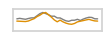

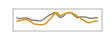

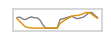

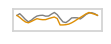

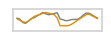

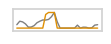

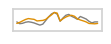

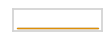

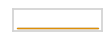

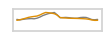

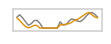

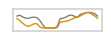

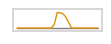

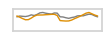

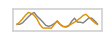

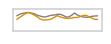

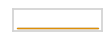

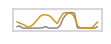

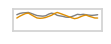

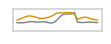

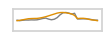

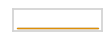

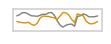

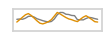

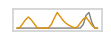

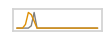

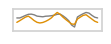

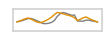

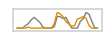

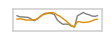

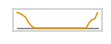

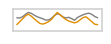

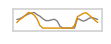

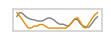

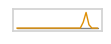

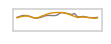

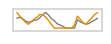

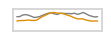

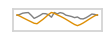

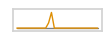

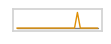

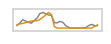

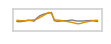

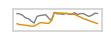

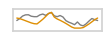

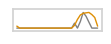

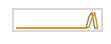

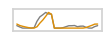

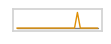

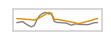

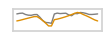

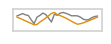

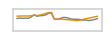

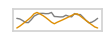

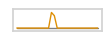

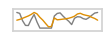

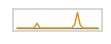

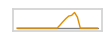

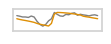

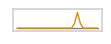

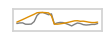

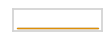

In [35]:
os.makedirs('3a', exist_ok=True)

for _iter in range(5):
    pre_df = pre_T_df[pre_T_df['model'] == model]
    pre_df = pre_df[pre_df['iteration'] == _iter]

    post_df = post_T_df[post_T_df['model'] == model]
    post_df = post_df[post_df['iteration'] == _iter]
    width = np.max(pre_df['x']) + 2
    height = np.max(pre_df['y']) + 2

    _sample = np.array(pre_df.head(1)['outputs'].item())
    n_units = _sample.size
    pre_heatmap = np.zeros((n_actions, n_units, width, height))
    post_heatmap = np.zeros((n_actions, n_units, width, height))

    for _, row in pre_df.iterrows():
        x = row['x']
        y = row['y']
        latents = np.array(row['outputs'])
        action = np.array(row['action'])
        pre_heatmap[action,:,x,y] = latents

    for _, row in post_df.iterrows():
        x = row['x']
        y = row['y']
        latents = np.array(row['outputs'])
        action = np.array(row['action'])
        post_heatmap[action,:,x,y] = latents

    goal_state = row['goal_state']

    for unit in range(n_units):
        plt.figure(
            figsize=(1, 0.33), constrained_layout=True)

        pre_m = np.mean(pre_heatmap[:,unit], axis=0)
        pre_m[pre_m<0] = 0
        if pre_m.max() > 0:
            pre_m /= pre_m.max()
        post_m = np.mean(post_heatmap[:,unit], axis=0)
        post_m[post_m<0] = 0
        if post_m.max() > 0:
            post_m /= post_m.max()
        plt.plot(retrieve_lineartrack(pre_m), color='gray')
        plt.plot(retrieve_lineartrack(post_m), color='C1')
        plt.xticks([]); plt.yticks([])
        ax = plt.gca()
        ax.tick_params(axis='y', colors='white')
        ax.spines['top'].set(visible=True)
        ax.spines['right'].set(visible=True)
        plt.ylim(-0.2, 1.2)
        plt.savefig(f'3a/{_iter}_{unit}.png', dpi=300, transparent=True)
        plt.show()

In [8]:
from scipy.stats import norm

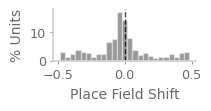

In [28]:
shifts = []
for _iter in range(30):
    pre_df = pre_T_df[pre_T_df['model'] == model]
    pre_df = pre_df[pre_df['iteration'] == _iter]
    post_df = post_T_df[post_T_df['model'] == model]
    post_df = post_df[post_df['iteration'] == _iter]
    if pre_df.empty or post_df.empty: continue

    width = np.max(pre_df['x']) + 2
    height = np.max(pre_df['y']) + 2

    _sample = np.array(pre_df.head(1)['outputs'].item())
    goal_state = pre_df.head(1)['goal_state'].item()
    n_units = _sample.size
    pre_heatmap = np.zeros((n_actions, n_units, width, height))
    post_heatmap = np.zeros((n_actions, n_units, width, height))
    goal_map = np.zeros((width, height))
    goal_map[goal_state[0], goal_state[1]] = 1
    goal_idx = np.argwhere(retrieve_lineartrack(goal_map)).item()
    len_track = len(retrieve_lineartrack(goal_map))
    
    for _, row in pre_df.iterrows():
        x = row['x']
        y = row['y']
        latents = np.array(row['outputs'])
        action = np.array(row['action'])
        pre_heatmap[action,:,x,y] = latents

    for _, row in post_df.iterrows():
        x = row['x']
        y = row['y']
        latents = np.array(row['outputs'])
        action = np.array(row['action'])
        post_heatmap[action,:,x,y] = latents
        
    for unit in range(n_units):
        pre_m = np.mean(pre_heatmap[:,unit], axis=0)
        pre_m = np.array(retrieve_lineartrack(pre_m))
        if pre_m.max() > 0:
            pre_peak = np.argwhere(pre_m == pre_m.max()).squeeze()
            if pre_peak.size == 1:
                pre_preak = pre_peak.item()
            else:
                pre_peak = pre_peak[0]
        post_m = np.mean(post_heatmap[:,unit], axis=0)
        post_m = np.array(retrieve_lineartrack(post_m))
        if post_m.max() > 0:
            post_peak = np.argwhere(post_m == post_m.max()).squeeze()
            if post_peak.size == 1:
                post_peak = post_peak.item()
            else:
                post_peak = post_peak[0]
        shift = post_peak - pre_peak
        equiv_shifts = np.array([shift-len_track, shift+len_track, shift])
        shift = equiv_shifts[np.argmin(np.abs(equiv_shifts))]
        shifts.append(shift)
shifts = [s/len_track for s in shifts]
plt.figure(figsize=(2, 1.), constrained_layout=True)
plt.hist(shifts, bins=25, alpha=0.4, color='black', weights=[100/len(shifts)]*len(shifts))
plt.axvline(0, color='black', linestyle='--', alpha=0.75)
plt.ylabel('% Units')
plt.xlabel('Place Field Shift')
plt.savefig('3b.png', dpi=300, transparent=True)
plt.show()

In [18]:
print(np.median(shifts))

-0.034482758620689655


# Plotting Value Warping

In [11]:
np.unique(pre_T_df['model'])

array(['lineartrack_g0_-2_entro-2', 'lineartrack_noq_g0_-2_entro-2'],
      dtype=object)

In [12]:
model = f'{generic_exp_name}_g0_-2_entro-2'

In [13]:
noq_model = f'{generic_exp_name}_noq_g0_-2_entro-2'

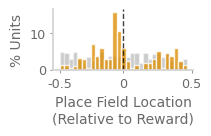

In [33]:
pre_m_peaks = []
post_m_peaks = []
for _iter in range(10):
    pre_df = post_T_df[post_T_df['model'] == noq_model]
    pre_df = pre_df[pre_df['iteration'] == _iter]

    post_df = post_T_df[post_T_df['model'] == model]
    post_df = post_df[post_df['iteration'] == _iter]

    width = np.max(pre_df['x']) + 2
    height = np.max(pre_df['y']) + 2

    _sample = np.array(pre_df.head(1)['outputs'].item())
    goal_state = pre_df.head(1)['goal_state'].item()
    n_units = _sample.size
    pre_heatmap = np.zeros((n_actions, n_units, width, height))
    post_heatmap = np.zeros((n_actions, n_units, width, height))
    goal_map = np.zeros((width, height))
    goal_map[goal_state[0], goal_state[1]] = 1
    goal_idx = np.argwhere(retrieve_lineartrack(goal_map)).item()
    len_track = len(retrieve_lineartrack(goal_map))
    
    for _, row in pre_df.iterrows():
        x = row['x']
        y = row['y']
        latents = np.array(row['outputs'])
        action = np.array(row['action'])
        pre_heatmap[action,:,x,y] = latents

    for _, row in post_df.iterrows():
        x = row['x']
        y = row['y']
        latents = np.array(row['outputs'])
        action = np.array(row['action'])
        post_heatmap[action,:,x,y] = latents
        
    for unit in range(n_units):
        pre_m = np.mean(pre_heatmap[:,unit], axis=0)
        pre_m = np.array(retrieve_lineartrack(pre_m))
        pre_m = np.roll(pre_m, shift=-np.random.choice(len_track))
        pre_m = np.roll(pre_m, shift=len_track//2)
        if pre_m.max() > 0:
            peak_locs = np.argwhere(pre_m == pre_m.max()).squeeze()
            if peak_locs.size == 1:
                pre_m_peaks.append(peak_locs.item())
            else:
                pre_m_peaks.extend(peak_locs.tolist())
        post_m = np.mean(post_heatmap[:,unit], axis=0)
        post_m = np.array(retrieve_lineartrack(post_m))
        post_m = np.roll(post_m, shift=-goal_idx)
        post_m = np.roll(post_m, shift=len_track//2)
        if post_m.max() > 0:
            peak_locs = np.argwhere(post_m == post_m.max()).squeeze()
            if peak_locs.size == 1:
                post_m_peaks.append(peak_locs.item())
            else:
                post_m_peaks.extend(peak_locs.tolist())
plt.figure(figsize=(2,1.25), constrained_layout=True)
n_pre = len(pre_m_peaks)
n_post = len(post_m_peaks)
plt.hist(
    pre_m_peaks, bins=len_track,
    alpha=0.4, color='gray', weights=[100/n_pre]*n_pre)
plt.hist(
    post_m_peaks, color='C1', bins=len_track,
    alpha=0.8, weights=[100/n_post]*n_post)
plt.axvline(len_track//2, color='black', linestyle='--', alpha=0.75)
plt.xlabel('Place Field Location\n(Relative to Reward)')
plt.ylabel('% Units')
plt.xticks([0, len_track//2, len_track], [-0.5, 0, 0.5])
plt.savefig('3c.png', dpi=300, transparent=True)
plt.show()

In [20]:
print(np.median(post_m_peaks)/len_track)

0.4482758620689655


In [21]:
print(np.median(pre_m_peaks)/len_track)

0.4827586206896552
